In [1]:
import pandas as pd
import geopandas as gpd
import geodatasets
import folium
from folium.plugins import MarkerCluster
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from shapely.geometry import Point

# Setting the path for convenience
data_dir = os.path.expanduser("~/multitressor/CREMP_CSV_Files")
print(f"Environment ready. Data directory set to: {data_dir}")

Environment ready. Data directory set to: /home/enrique.montes@CNS.local/multitressor/CREMP_CSV_Files


#### Load data and render map showing location of CREMP monitoring sites

In [2]:
# 1. Load the dataset
stations_path = os.path.join(data_dir, "CREMP_Stations_2024.csv")
df_stations = pd.read_csv(stations_path)

# 2. Initialize the map with Satellite Imagery
# We use Esri.WorldImagery for the satellite background
m = folium.Map(
    location=[24.8, -80.8], 
    zoom_start=8, 
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri Satellite'
)

# 3. Add stations to the map
marker_cluster = MarkerCluster().add_to(m)

for idx, row in df_stations.iterrows():
    if pd.notnull(row['latDD']) and pd.notnull(row['lonDD']):
        # Popup string formatted as a list-style block
        popup_text = f"""
        Station: {row.get('Site_name', 'N/A')}
        <br>ID: {row.get('StationID', 'N/A')}
        <br>Habitat: {row.get('Habitat', 'N/A')}
        <br>First Surveyed: {row.get('First_Year_surveyed', 'N/A')}
        <br>Depth: {row.get('Depth_ft', 'N/A')} ft
        """
        
        folium.Marker(
            location=[row['latDD'], row['lonDD']],
            popup=folium.Popup(popup_text, max_width=300),
            tooltip=row.get('Site_name', 'Click for info')
        ).add_to(marker_cluster)

# Display the map
m

#### Benthic trend analysis and mapping

Linear Trend Analysis (Total Stony Coral Cover):


,SiteName,Slope,P_Value
38,Turtle,0.000477,0.159845
40,West Turtle Shoal,0.000208,0.554128
10,Dove Key,0.000013,0.902454
25,Rattlesnake,-0.000043,0.796175
14,El Radabob,-0.000051,0.255487
21,Molasses Keys,-0.000054,0.205656
20,Molasses Deep,-0.000082,0.709174
24,Porter Patch,-0.000132,0.431244
7,Conch Deep,-0.000133,0.618767
1,Alligator Deep,-0.000167,0.165692


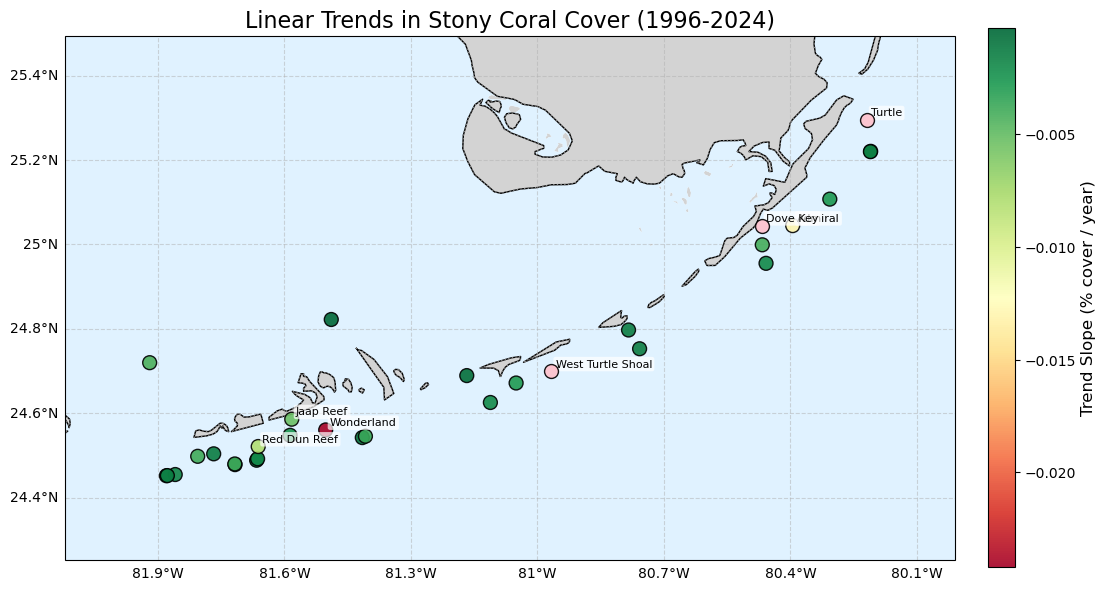

In [ ]:
# Load data and calculate trends
pcover_path = os.path.join(data_dir, "CREMP_Pcover_StonyCoralSpecies_2024.csv")
df_pcover = pd.read_csv(pcover_path)

species_cols = df_pcover.columns[11:] 
df_pcover['Total_Cover'] = df_pcover[species_cols].sum(axis=1)
site_annual = df_pcover.groupby(['SiteName', 'SampleYear'])['Total_Cover'].mean().reset_index()

stats_list = []
for site in site_annual['SiteName'].unique():
    site_data = site_annual[site_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data['Total_Cover'])
        stats_list.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_trends = pd.DataFrame(stats_list)

# Display the trend table
print("Linear Trend Analysis (Total Stony Coral Cover):")
display(df_trends.sort_values('Slope', ascending=False).head(10)) 

# Merge with coordinates
df_coords = df_stations[['Site_name', 'latDD', 'lonDD']].drop_duplicates(subset='Site_name')
df_map_data = pd.merge(df_trends, df_coords, left_on='SiteName', right_on='Site_name')

# Filter data to only include significant trends
df_significant = df_map_data[df_map_data['P_Value'] < 0.05].copy()
df_pos = pd.merge(df_trends[df_trends['Slope'] >= 0], df_coords, left_on='SiteName', right_on='Site_name')

# Setup the figure with a PlateCarree projection
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add high-resolution geographic features
# '10m' provides the highest resolution for coastal details
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.STATES.with_scale('10m'), linestyle=':', edgecolor='gray')
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# Plot ONLY the significant trend dots
# We use scatter because your reef data is point-based
sc = ax.scatter(df_significant['lonDD'], df_significant['latDD'], 
                c=df_significant['Slope'], cmap='RdYlGn', 
                s=100, edgecolor='black', alpha=0.9, 
                transform=ccrs.PlateCarree(), zorder=3)

# 3. Plot stable/increasing sites (>= 0) as PINK
ax.scatter(df_pos['lonDD'], df_pos['latDD'], 
           color='pink', # Explicitly colored pink
           label='Stable/Increasing (≥ 0)',
           s=100, edgecolor='black', alpha=0.9, 
           transform=ccrs.PlateCarree(), zorder=4)

# Set the map extent to focus on the Florida Keys / study area
# [min_lon, max_lon, min_lat, max_lat]
ax.set_extent([df_map_data['lonDD'].min() - 0.2, df_map_data['lonDD'].max() + 0.2,
               df_map_data['latDD'].min() - 0.2, df_map_data['latDD'].max() + 0.2], 
              crs=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.03, shrink=0.7)
cbar.set_label('Trend Slope (% cover / year)', fontsize=12)

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, zorder=2)
gl.top_labels = False
gl.right_labels = False

# Labels for significant sites (p < 0.05)
for idx, row in df_map_data.iterrows():
    if row['Slope'] <= -0.005 or row['Slope'] >= 0:
        ax.text(row['lonDD'] + 0.01, row['latDD'] + 0.01, row['SiteName'],
                fontsize=8, transform=ccrs.PlateCarree(),
                bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7, ec='none'))

plt.title('Linear Trends in Stony Coral Cover (1996-2024)', fontsize=16)
plt.show()

#### Species-level trend analysis

Species-Level Trend Analysis (All Sites Integrated):


,Species,Slope,P_Value,R_Squared
30,Orbicella_annularis_complex,-9.654588e-04,4.927405e-13,0.859826
44,Total_Cover,-8.530729e-04,8.512871e-04,0.342622
0,Acropora_palmata,-1.907967e-04,8.249014e-05,0.442493
22,Millepora_complanata,-1.226949e-04,1.681630e-03,0.310715
36,Scleractinia,-9.025361e-05,4.656423e-05,0.464768
23,Montastraea_cavernosa,-6.193687e-05,1.242067e-01,0.085300
9,Dendrogyra_cylindrus,-4.880537e-05,2.215128e-13,0.867845
35,Pseudodiploria_strigosa,-3.630759e-05,3.918590e-04,0.377447
8,Colpophyllia_natans,-2.132709e-05,7.151408e-01,0.005013
11,Diploria_labyrinthiformis,-2.118424e-05,1.043691e-05,0.519164


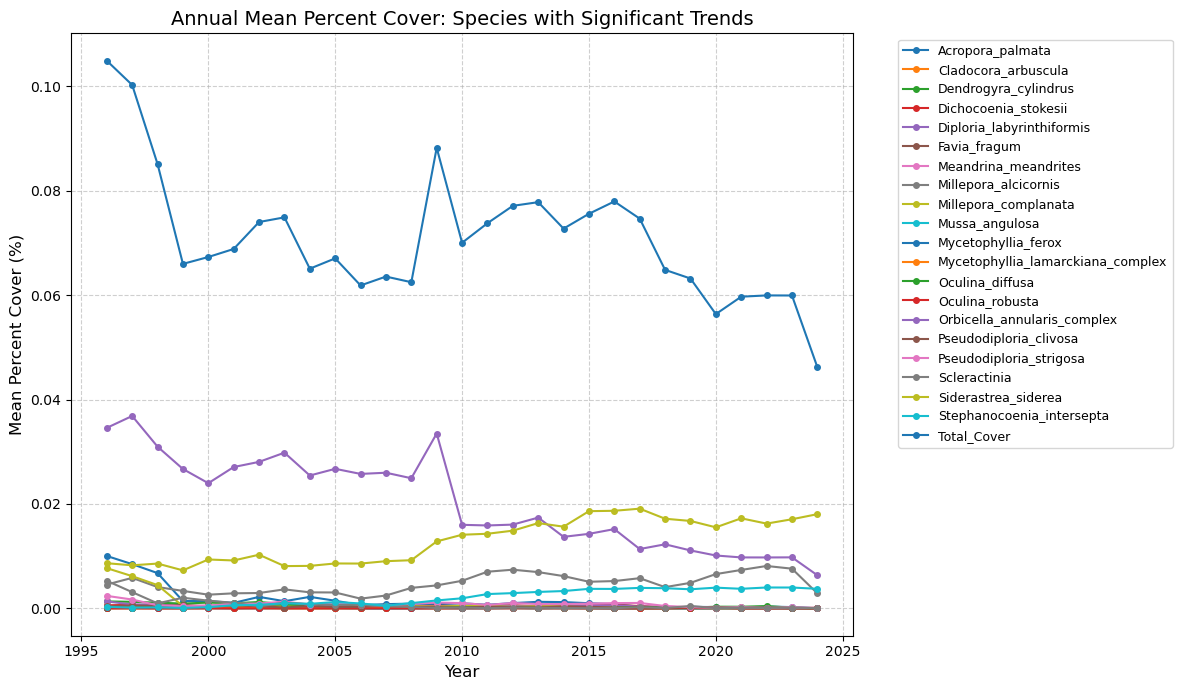

In [12]:
# Identify species columns (from index 11 onwards)
species_list = df_pcover.columns[11:].tolist()

# Aggregate data by Year for the entire region
# Calculate the mean percent cover for every species across all sites per year
species_annual = df_pcover.groupby('SampleYear')[species_list].mean().reset_index()

# Calculate Linear Trends for each species
species_stats = []

for species in species_list:
    # Remove years where the species might have zero data if necessary. 
    y = species_annual[species]
    x = species_annual['SampleYear']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    species_stats.append({
        'Species': species,
        'Slope': slope,
        'P_Value': p_value,
        'R_Squared': r_value**2
    })

df_species_trends = pd.DataFrame(species_stats)

# Identify significant species (p < 0.05)
significant_species = df_species_trends[df_species_trends['P_Value'] < 0.05].copy()

print("Species-Level Trend Analysis (All Sites Integrated):")
display(df_species_trends.sort_values('Slope', ascending=True))

# Render Time Series Plot for Significant Species Only
if not significant_species.empty:
    plt.figure(figsize=(12, 7))
    
    for species in significant_species['Species']:
        plt.plot(species_annual['SampleYear'], species_annual[species], 
                 marker='o', markersize=4, label=f"{species}")

    plt.title('Annual Mean Percent Cover: Species with Significant Trends', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean Percent Cover (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No species showed statistically significant trends.")

#### Check stations where a selected species shows a significant (p < 0.05) trend

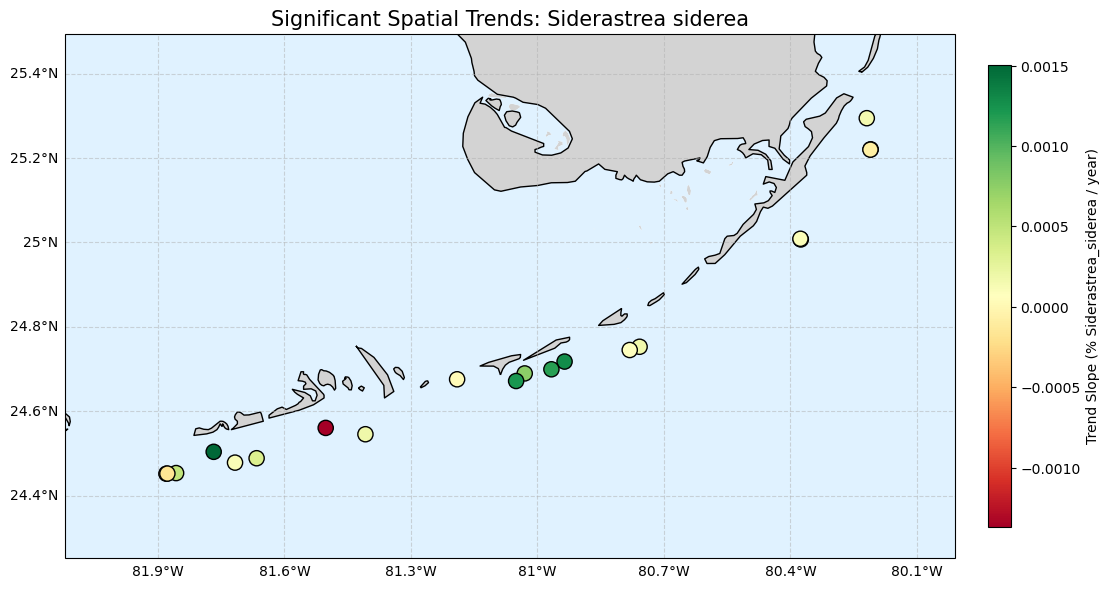

In [14]:
# --- Spatial Analysis for a Selected Species ---
selected_species = 'Siderastrea_siderea'

# Group by Site and Year for the specific species
site_species_annual = df_pcover.groupby(['SiteName', 'SampleYear'])[selected_species].mean().reset_index()

# Calculate trends for this species at each individual site
site_species_stats = []
for site in site_species_annual['SiteName'].unique():
    site_data = site_species_annual[site_species_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data[selected_species])
        site_species_stats.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_species_map = pd.DataFrame(site_species_stats)

# Merge with coordinates and filter for significance (p < 0.05)
df_species_map = pd.merge(df_species_map, df_coords, left_on='SiteName', right_on='Site_name')
df_sig_map = df_species_map[df_species_map['P_Value'] < 0.05].copy()

# Render the Map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add High-Res Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# Plot Trends
sc = ax.scatter(df_sig_map['lonDD'], df_sig_map['latDD'], 
                c=df_sig_map['Slope'], cmap='RdYlGn', 
                s=120, edgecolor='black', transform=ccrs.PlateCarree(), zorder=3)

# Add Legend/Colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
cbar.set_label(f'Trend Slope (% {selected_species} / year)')

# Set extent and labels
ax.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
               df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title(f'Significant Spatial Trends: {selected_species.replace("_", " ")}', fontsize=15)
plt.show()

#### Check stations where a selected taxa group shows a significant (p < 0.05) trend

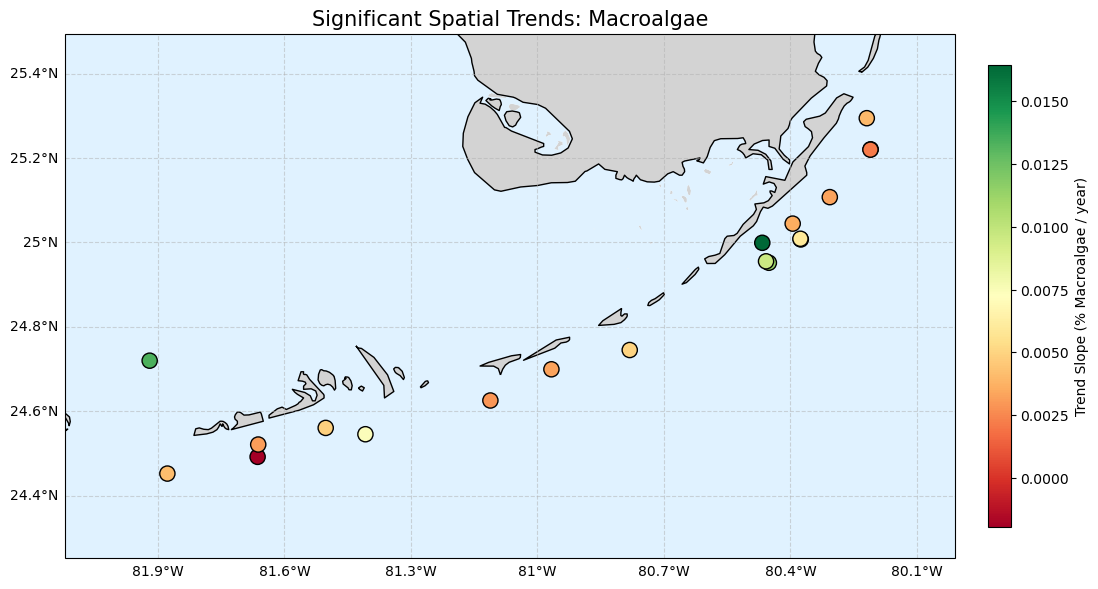

In [17]:
taxagroups_path = os.path.join(data_dir, "CREMP_Pcover_TaxaGroups_2024.csv")
df_taxagroups = pd.read_csv(taxagroups_path)

# --- Spatial Analysis for a Selected Group ---
selected_group = 'Macroalgae'

# Group by Site and Year for the specific group
site_taxa_annual = df_taxagroups.groupby(['SiteName', 'SampleYear'])[selected_group].mean().reset_index()

# Calculate trends for this group at each individual site
site_taxa_stats = []
for site in site_taxa_annual['SiteName'].unique():
    site_data = site_taxa_annual[site_taxa_annual['SiteName'] == site]
    if len(site_data) > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(site_data['SampleYear'], site_data[selected_group])
        site_taxa_stats.append({'SiteName': site, 'Slope': slope, 'P_Value': p_value})

df_taxa_map = pd.DataFrame(site_taxa_stats)

# Merge with coordinates and filter for significance (p < 0.05)
df_taxa_map = pd.merge(df_taxa_map, df_coords, left_on='SiteName', right_on='Site_name')
df_sig_map = df_taxa_map[df_taxa_map['P_Value'] < 0.05].copy()

# Render the Map
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add High-Res Features
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1)
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#e0f2ff')

# Plot Trends
sc = ax.scatter(df_sig_map['lonDD'], df_sig_map['latDD'], 
                c=df_sig_map['Slope'], cmap='RdYlGn', 
                s=120, edgecolor='black', transform=ccrs.PlateCarree(), zorder=3)

# Add Legend/Colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.6, pad=0.03)
cbar.set_label(f'Trend Slope (% {selected_group} / year)')

# Set extent and labels
ax.set_extent([df_coords['lonDD'].min()-0.2, df_coords['lonDD'].max()+0.2, 
               df_coords['latDD'].min()-0.2, df_coords['latDD'].max()+0.2])
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

plt.title(f'Significant Spatial Trends: {selected_group.replace("_", " ")}', fontsize=15)
plt.show()

#### Plot time series of taxa groups

Taxa-Level Trend Analysis (All Sites Integrated):


,Taxa,Slope,P_Value,R_Squared
6,Substrate,-0.004555,6.380539e-05,0.452601
5,StonyCoral,-0.000882,8.055304e-04,0.345156
4,Seagrass,-0.000251,9.668129e-07,0.595040
2,Others,0.000072,1.335394e-02,0.206165
9,Zoanthidea,0.000136,5.170524e-03,0.255365
1,Octocoral,0.000857,6.082549e-02,0.124167
3,Porifera,0.000936,1.157462e-06,0.589727
0,Macroalgae,0.002740,2.480944e-04,0.397200
7,Unknown,NaN,NaN,NaN
8,Urchins,NaN,NaN,NaN


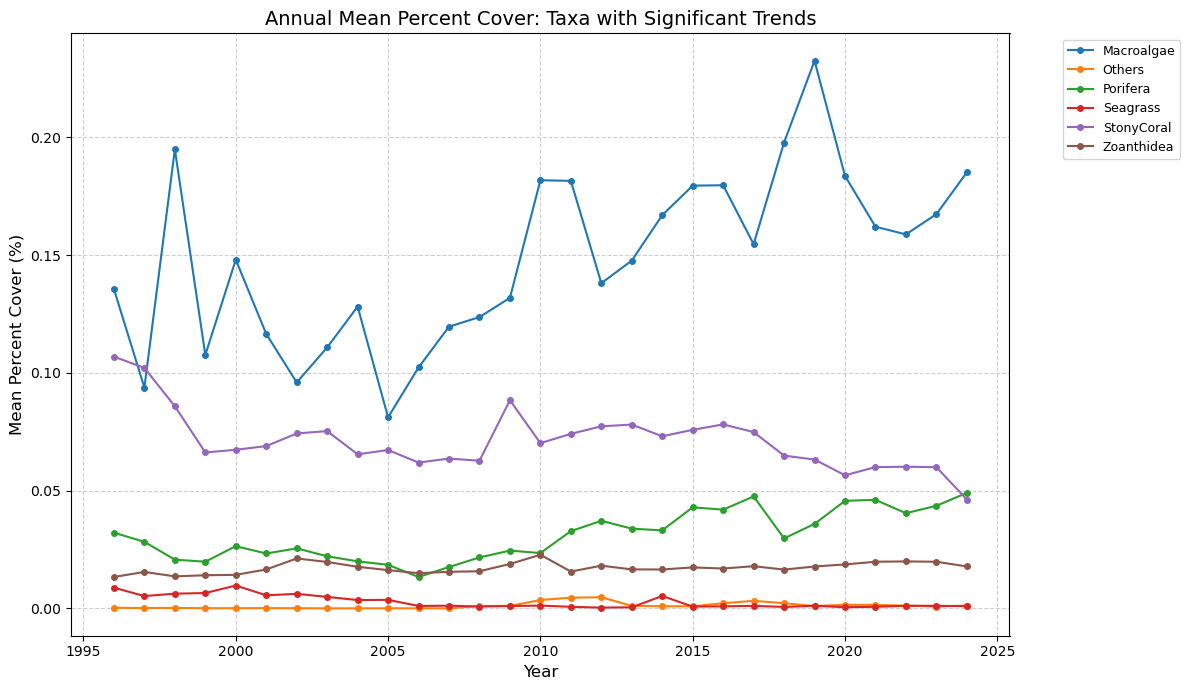

In [21]:
# Identify taxa columns (from index 11 onwards)
taxa_list = df_taxagroups.columns[11:].tolist()

# Aggregate data by Year for the entire region
# Calculate the mean percent cover for every taxa across all sites per year
taxa_annual = df_taxagroups.groupby('SampleYear')[taxa_list].mean().reset_index()
# Calculate Linear Trends for each taxa
taxa_stats = []

for taxa in taxa_list:
    # Remove years where the taxa might have zero data if necessary. 
    y = taxa_annual[taxa]
    x = taxa_annual['SampleYear']
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    taxa_stats.append({
        'Taxa': taxa,
        'Slope': slope,
        'P_Value': p_value,
        'R_Squared': r_value**2
    })

df_taxa_trends = pd.DataFrame(taxa_stats)

# Identify significant taxa (p < 0.05)
significant_taxa = df_taxa_trends[df_taxa_trends['P_Value'] < 0.05].copy()

print("Taxa-Level Trend Analysis (All Sites Integrated):")
display(df_taxa_trends.sort_values('Slope', ascending=True))

# Render Time Series Plot for Significant Taxa Only (Excluding Substrate)
if not significant_taxa.empty:
    plt.figure(figsize=(12, 7))

    for taxa in significant_taxa['Taxa']:
        # --- Skip 'Substrate' ---
        if taxa == 'Substrate':
            continue
            
        plt.plot(taxa_annual['SampleYear'], taxa_annual[taxa], 
                 marker='o', markersize=4, label=f"{taxa}")

    plt.title('Annual Mean Percent Cover: Taxa with Significant Trends', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Mean Percent Cover (%)', fontsize=12)
    
    # The legend will now automatically exclude Substrate because it was never plotted
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("No species showed statistically significant trends.")